# Basic example of PLS calibration and regression
This example illustrates the basic workflow in chemometrics for calibrating a PLS model with real-world data. For this, we will mainly leverage the functionality of `chemometrics.fit_pls`. Let's first start with loading the libraries which we will use through-out this tutorial:

In [1]:
# load libraries for data processing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import chemometrics as cm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

ImportError: cannot import name 'ConstraintNonneg' from 'chemometrics.mcr.constraints' (/home/matthias/workspace/chemometrics/chemometrics/mcr/constraints.py)

We will use real-world, open-source NIR data for this tutorial published by Daniel Pelliccia ([Repository](https://raw.githubusercontent.com/nevernervous78/nirpyresearch/master/data/peach_spectra_brix.csv)). The data set consists of 50 NIR spectra of fresh peaches, probably measured in diffuse reflectance mode. The spectra were measured from 1100 nm to 2300 nm in steps of 2 nm. Reference values are provided in brix, i.e. the sugar content. The data is available over Github and an analysis has been previously performed with PLS modeling and Savitzky-Golay filtering by Daniel ([NIRPy Research](https://nirpyresearch.com/partial-least-squares-regression-python/)). While Daniel only relied on NumPy, sklearn, pandas and matplotlib, we will additionally use chemometrics. This will give us some added benefits such as a lean way to calibrate our PLS, improved analytics for the calibrated PLS model, access to the Whittaker filter and improved plotting.

Let's start by loading the spectra. pandas provides the option to directly read a csv file from an URL, which we will use to directly load the data from the GitHub repository. After loading, we will split the data set into our predictors and response variables X and Y, respectively.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/nevernervous78/nirpyresearch/master/data/peach_spectra_brix.csv')
X = df.iloc[:, 1:].values
Y = df.iloc[:, 0].values[:, None]

Let's take a first look at our data. We'll use the colored line plot `plot_colored_series`, which colors the lines according to the reference data. Typically, this helps to see any obvious spectral trends related to the response.

Text(0, 0.5, 'Absorbance / mAU')

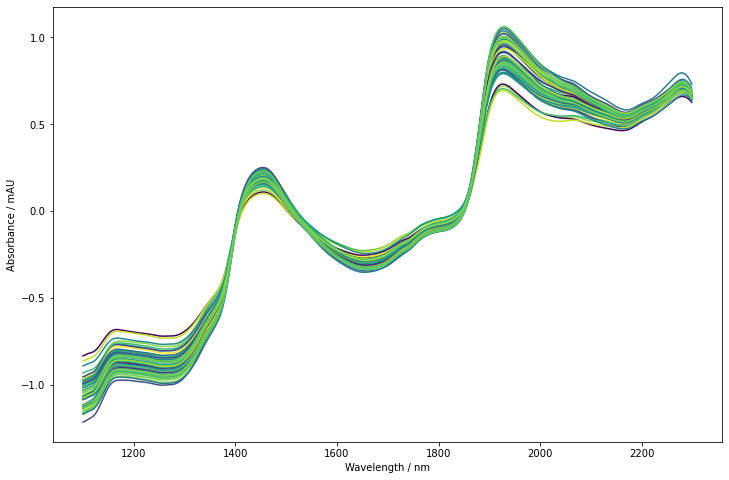

In [3]:
wavelengths = np.arange(1100, 2300, 2)
fig = plt.figure(figsize=(12, 8))
lines = cm.plot_colored_series(X.T, x=wavelengths, reference=Y[:, 0])
plt.xlabel('Wavelength / nm')
plt.ylabel('Absorbance / mAU')

As it is common for NIR spectra, the trends are dominated by background effects. The spectra are slanted and show an offset. The pronounced bands around 1500 nm and 2000 nm are water overtones/combination modes probably with contributions of other chemical components. The band around 1200 nm may also contain 2nd overtone contributions from water. At the upper and lower end of the spectra, we can see that the offset and slant is not for all spectra reproducible. It thus makes sense to use some form of preprocessing. 

We will here follow the approach also used by NIRPy Research and rely on a second derivative for removing background effects. We will however not use a Savitzky-Golay filter but instead rely on the Whittaker filter for smoothing and derivation. The biggest advantage is that the `Whittaker` implementation provides an autofit functionality. We thus do not have to concern ourself with setting good smoothing parameters. Instead, `Whittaker` provides an autofitted value with some guarantees on optimality. (Note: in this specific example, smoothing is very weak indicating that there is little to no uncorrelated noise in the predictor variables. We will not go further into details on this in this specific example. If you want to further dig in, take a look at the documentation of `Whittaker` and its plotting capability. Also [this example](https://github.com/maruedt/chemometrics/blob/master/examples/whittaker.ipynb) might be interesting.) Furthermore, `Whittaker` efficiently smooths the edges of the spectra (no truncation) and allows for continuous adaption of the smoothing parameter.

Since we want to use a second derivative, it is recommended to set a constraint order which is at least as high as the level of differentiation, i.e. in our case >=2. The `Whittaker` filter uses the same notation as any preprocessor available from sklearn. We will thus generate the filter and use `fit_transform` to directly obtain the filtered spectra. The spectra are again plotted using the `plot_colored_series` functionality to see if any obvious correlations are visible.

Text(0, 0.5, '$d^2A/dl^2$ / $mAU/nm^2$')

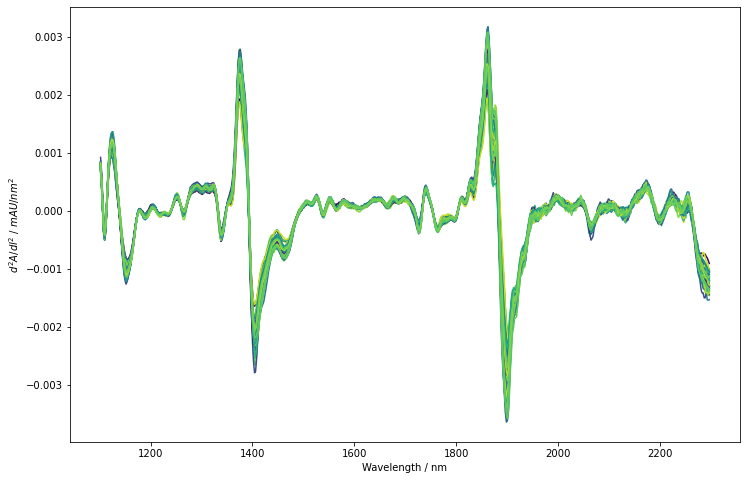

In [4]:
X_deriv = cm.Whittaker(constraint_order=3, deriv=2).fit_transform(X)

fig = plt.figure(figsize=(12, 8))
lines = cm.plot_colored_series(X_deriv.T, x=wavelengths[1:-1], reference=Y[:, 0])
plt.xlabel('Wavelength / nm')
plt.ylabel('$d^2A/dl^2$ / $mAU/nm^2$')

The derivation successfully removed the background offset and slant from spectra. They are now nicely aligned but we actually only see minor differences between the different spectra.
Also, noise does not seem to significantly impact the derived spectra. To get a perspective similar to the PLS model, we will now perform a mean-centering of each predictor column. The obtained spectra are again plotted. Additionally, a small insert shows a zoom in on the baseline between 1100 nm and 1300 nm to give an impression on the noise level compared to small spectral features.

(-0.0003, 0.0003)

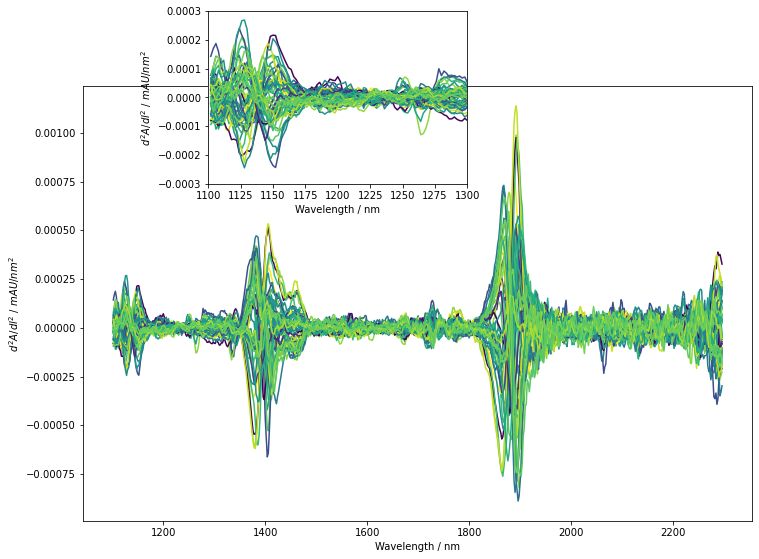

In [5]:
scaler = StandardScaler(with_std=False)

X_preprocessed = scaler.fit_transform(X_deriv)

plt.figure(figsize=(12, 8))
lines = cm.plot_colored_series(X_preprocessed.T, x=wavelengths[1:-1], reference=Y[:, 0])
plt.xlabel('Wavelength / nm')
plt.ylabel('$d^2A/dl^2$ / $mAU/nm^2$')

plt.axes(arg=(0.27, 0.71, 0.3, 0.3))
lines = cm.plot_colored_series(X_preprocessed.T, x=wavelengths[1:-1], reference=Y[:, 0])
plt.xlabel('Wavelength / nm')
plt.ylabel('$d^2A/dl^2$ / $mAU/nm^2$')
plt.xlim([1100, 1300])
plt.ylim([-3e-4, 3e-4])

Also after mean-centering, no region shows a striking correlation to our response variable. We can however see clusterings of color indicating at least some correlation. For example such a trend seems to occure in the wavelength region displayed in the insert around 1200 nm to 1250 nm. In this region, the spectra with higher brix values display a minimum and a maximum while low brix samples remain rather constant. After mean-centering, some noise is visible in the predictors. Compared to the spectral feature mentioned before, the noise does not obscure but remains distinctlively smaller. For this example, we will not try to further reduce the noise level. 

We'll now directly proceed to fitting a PLS model. We will use the standard workflow of chemometrics `fit_pls`. In its simplest version, the function takes just a set of predictor and response variables and autofits a PLS regression model. The optimal number of latent variables is defined based on maximizing the median coefficient of determination during a 5-fold cross-validation. The method automatically plots analytical results including the results from cross validation as well as information on the model. A dictonary with performance information is returned along with the fitted model. We will however deviate from the simplest case by adjusting the PLS model slightly. chemometrics' `PLSRegression` object does not standardize the predictors by default, which often makes sense for spectroscopic data. In our case, the largest contributions to the spectra are however variations in the water bands. To increase the contribution of other features to the overall spectra, a standardization is helpful. For this, we will set the `scale`-attribute of `PLSRegression` to `True`. Additionally to the analytics automatically plotted by `fit_pls`, we will also print the $R^2$ and the $Q^2$ values of the model. With that, let's fit the model.

Optimal number of latent variables: 3
R2: 0.730100551115276
Q2: 0.44126376324479666


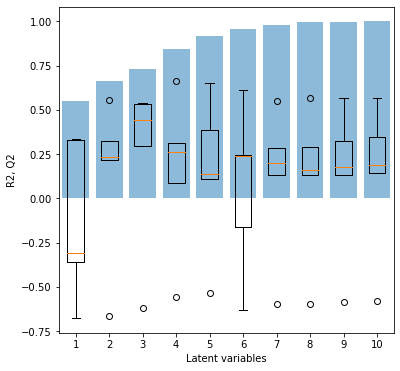

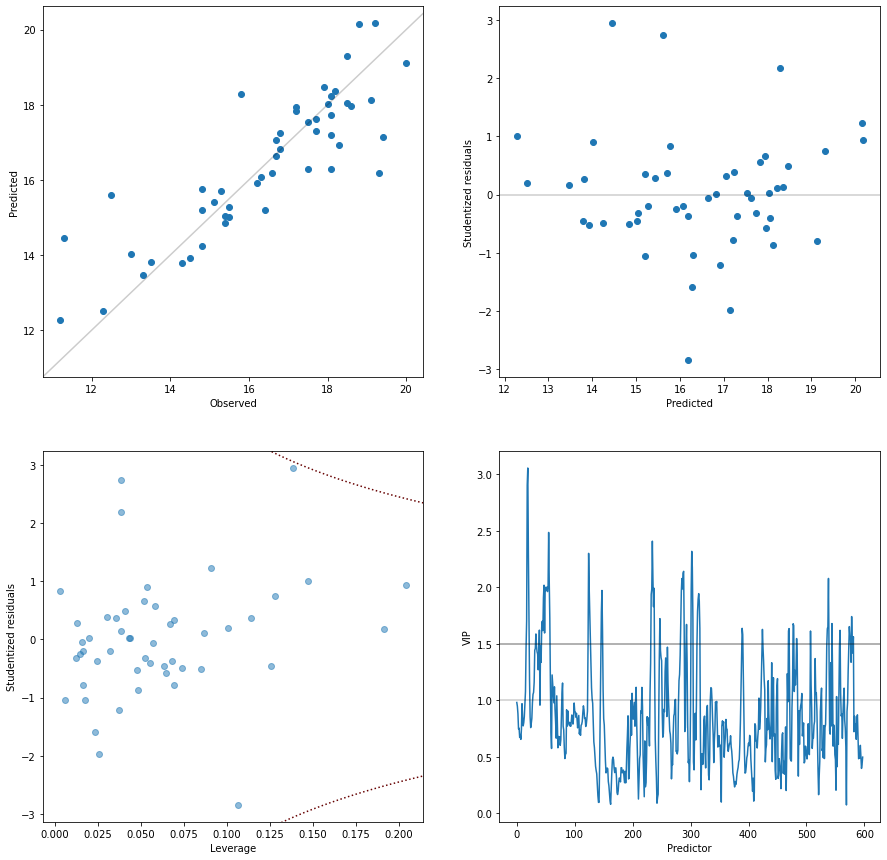

In [6]:
model, analytics = cm.fit_pls(X_deriv, Y, pipeline=make_pipeline(cm.PLSRegression(scale=True)))
r2 = analytics['r2'][analytics['optimal_lv']-1]
q2 = analytics['q2_median'][analytics['optimal_lv']-1]
print(f'Optimal number of latent variables: {analytics["optimal_lv"]}')
print(f'R2: {r2}')
print(f'Q2: {q2}')

As can be seen above, `fit_pls` successfully completed and printed out five plots. We'll now look at those plots and interpret the results to get some background information on our model.

The first plot on the cross-validation shows the model performance with different numbers of latent variables. While the blue bars show the R2, i.e. the model performance calibrated on the whole dataset, the boxplot gives insight on the model performance during the different rotations of cross-validation. The orange bar is the median performance, while the box shows the 0.25 and 0.75 quantile. Outliers are indicated by flier points. What we can now immediately see is that the five-fold cross-validation leads to one strong outlier/under-performing calibration independent of the number of latent variables. The five-fold cross-validation does not implement a shuffle. It seems reasonable to assume that always the calibration on the same subset is responsible for generating the outlier score. It furthermore indicates, that a few samples may be quite important for the model calibration, i.e. if certain samples are missing, the model performance degenerates. Based on the cross-validation plot, we can also see that 3 latent variables give the best performance during cross-validation.

The four following plots provide insight into the calibration of the final, optimal model. On the top left, the observed versus predicted gives a simple overview of how the model prediction compares to the measured values. The expectation is that the points align along the parity line. The plot shows us that we do not have any obvious nonlinearities or a bias in the model. The second plot provides insight if the residuals are comparable over the whole prediction range. The residuals are studentized and thus, all should fall into the range -3 to 3, otherwise they should be considered outliers and further investigated. We do not see distinc patterns or heteroscedasity - the residual distribution seems to be relatively homogeneous over the whole model scale. In the third plot, the leverage is plotted versus residuals. The leverage is a measure for the impact each sample has on the overall model. The `PLSRegression` calculates the leverage of each point in the latent variable space. We thus do primarily see if a sample has a significant influence on the model in the latent variable space. The leverage does not show directly, how big the influence of the samples was for obtaining the direction of the latent variables. However, a sample with a large influence on the latent variable directions will typically also have large score values thus increasing the leverage indirectly. As a guidance when a sample has a large influence on the model, the Cook's distance of 0.5 is added to the plot as a dashed line. In our case, we get some samples with a bigger influence but non, which exceeds the cooks distance of 0.5. Thus, non of the samples have an exceedingly large impact on model calibration. So far so good. These three plots thus provide insights into the model regarding the latent variable space in combination with the model output (predicted/residuals). 

The final plot is more concerned with how the spectra are mapped into the latent variable space. The plot shows the variable importance in projection (VIP) over the predictors. The VIP is a normalized measure for how important the different wavelengths are for predicting the PLS response. Generally, variables with a score >1 are above the mean squared VIP value and may thus be considered important for the model. For a good model, we want the VIPs to follow the perceived/expected information content. For spectroscopy, we would typically want some continuity and not too much 'jumpiness' (which may indicate overfitting). Furthermore, we typically don't want the (spectroscopic) PLS model to leverage only one or two wavelengths for the prediction since the model would then be more susceptible to measurment noise. On the other hand, a very flat VIP curve indicates that all variables are similarily important which could either mean that the background is the main information source or the predictors do not provide a lot of information on  the response variables. Looking at the obtained VIP for our model, they seem to adhere to these criteria. The important spectroscopic features used by the model are rather small and with limited spectral bandwidth. To get a more in depth picture of which spectral features are important, we will generate an extra plot below which overlays the preprocessed spectra with the VIPs.

Text(0, 0.5, 'VIP')

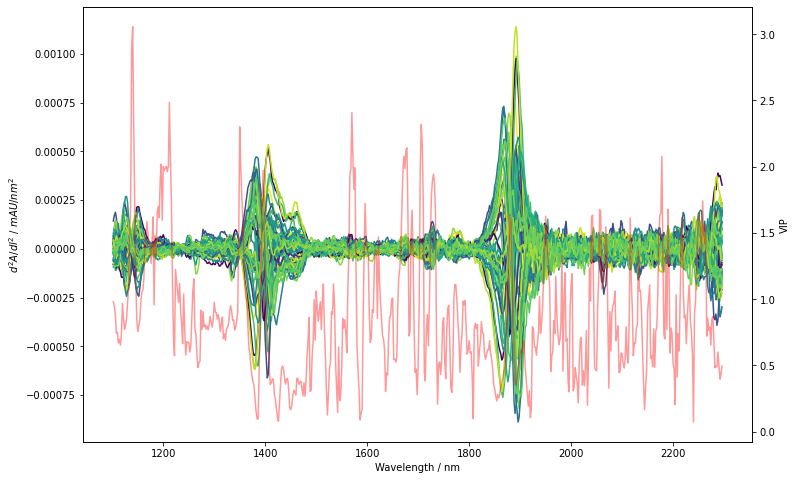

In [7]:
fig, ax1 = plt.subplots(figsize=(12,8))
lines = cm.plot_colored_series(X_preprocessed.T, x=wavelengths[1:-1], reference=Y[:, 0])
plt.xlabel('Wavelength / nm')
plt.ylabel('$d^2A/dl^2$ / $mAU/nm^2$')
#plt.xlim([1100, 1300])
#plt.ylim([-3e-4, 3e-4])

ax2 = ax1.twinx()
ax2.plot(wavelengths[1:-1], model[-1].vip_, 'r', alpha=0.4)
#plt.ylim([0, 5])
plt.ylabel('VIP')

As hinted above, we do see a correlation of VIPs with chemical variation. Note for example, that the region which we already spotted previously between 1200 nm to 1250 nm overlaps with very high VIP scores >=2. Other regions in the spectra also seem to be similar important. We could now easily proceed and use the VIP for variable selection e.g. by only using variables with a VIP score >=1 (`X_reduced = X_deriv[:, model[-1].vip_ >= 1]`). This further improves the Q2 and model reliability by removing unimportant variables. The variable reduction will however not be done in this tutorial. Rather, we'll continue with some overall model considerations.

Can we now be sure that the model uses really spectral features generated by sugar? Maybe :-). We do have a reasonable - although far from good - model performance during cross-validation of 0.44. We do see that the model uses distinct spectral features for prediction. A measurement of the relevant pure sugars or some literature research could provide additional information on whether the correlated spectral features are indeed typical for carbohydrates. 

Finally, a quick comparison to the model calibrated by Daniel from NIRPyResearch is made. Daniel's final model reached a Q2 value of 0.451 with 7 latent variables and ten fold cross-validation. So overall, while using less latent variables, our model reaches a comparable performance. The comparison however has to be taken with a grain of salt since we used: 
- a different procedure for calculating the Q2 (median, which is robust against outliers and we did have low-performance outliers --> the median improves the observed Q2). 
- a cross-validation over only 5 groups (which is more challenging for the model, making the Q2 worse). 

The R2 for our model is smaller, reaching only 0.73 compared to 0.859 by Daniel's model. Typically, a smaller spread between R2 and Q2 is considered positive, while an increased spread may indicate overfitting. Overall, I would nevertheless say, that the two final PLS models are comparable. Which to choose for an application may be considered personal taste.

We have reached the end of this tutorial. Hopefully, this gave you some insights on how chemometrics may be used to effectively calibrate a PLS model and use the generated plots to tickle some interesting information out of a calibrated model.